# This notebook is for the development of a pipeline for unsupervised learning on accelerometer data. 

## Pyhsmm is tested on the SMOVE dataset.

### Part 0: Imports

In [33]:
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import pyhsmm
import pyhsmm.basic.distributions as distributions
from pyhsmm.util.text import progprint_xrange
from scipy import stats
import statistics 

### Part 1: Data parsing

In [2]:
data_location = "/home/jack/data/SMOVE_dataset_v0.1"

# Creates strings for parsing over the file structure of the dataset
participant_IDs = ["P" + str(x) for x in range(4,9)]

In [3]:
# The data from each participant is stored into a dictionary
SMOVE_data = {}
for participant in participant_IDs:
    SMOVE_data[participant] = pd.read_pickle(r'{0}/{1}/acc_data_{1}.pickle'.format(data_location, participant))

In [4]:
# The data from the different devices are stored as a dictionary.
for device in SMOVE_data["P4"]:
    print(device)

# Example of the data from a device
SMOVE_data["P4"]["waist"]

waist
lower_back
left_wrist
right_wrist
left_upper_arm
right_upper_arm
left_shank
right_shank
left_thigh
right_thigh
sternum


accX      accY      accZ  label
timestamp                                     
0.0       -9.507906 -0.180554 -1.647339    0.0
20.0      -9.465234 -0.143903 -1.753500    0.0
40.0      -9.448027 -0.279861 -1.953387    0.0
60.0      -9.425528 -0.234681 -2.000758    0.0
80.0      -9.458136 -0.220903 -1.990725    0.0
...             ...       ...       ...    ...
3736300.0 -8.400777  0.206534 -4.467836    NaN
3736320.0 -8.400777  0.206534 -4.467836    NaN
3736340.0 -8.400777  0.206534 -4.467836    NaN
3736360.0 -8.400777  0.206534 -4.467836    NaN
3736380.0 -8.400777  0.206534 -4.467836    NaN

[186820 rows x 4 columns]

### Part 2: Basic plotting

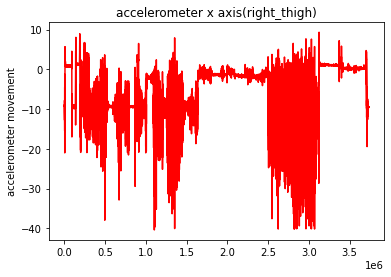

In [5]:
plt.plot(SMOVE_data["P4"]["right_thigh"]["accX"], color="red")
plt.title("accelerometer x axis(right_thigh)")
plt.ylabel("accelerometer movement")
plt.show()

In [6]:
plt.plot(SMOVE_data["P4"]["right_thigh"]["accY"], color="blue")
plt.title("accelerometer y axis(right_thigh)")
plt.ylabel("accelerometer movement")
plt.show()

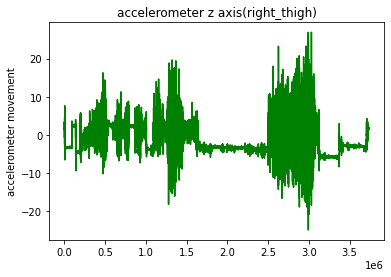

In [7]:
plt.plot(SMOVE_data["P4"]["right_thigh"]["accZ"], color="green")
plt.title("accelerometer z axis(right_thigh)")
plt.ylabel("accelerometer movement")
plt.show()

### Part 3: Windows

The data of each participant is split into windows of a certain amount of seconds

In [8]:
def split_into_windows(data, nrows_per_window):
    # Splits input data into windows based on given amount of rows per window.
    return [data[i:i+nrows_per_window] for i in range(0,data.shape[0],nrows_per_window)]

In [9]:
# The sampling rate of the devices
hertz = 50
# the size of the windows in seconds
window_length = 5
nrows_per_window = int(window_length / (1 / hertz))

In [10]:
windowed_data = {}
all_windows = []
for participant in SMOVE_data:
    
    # FOR NOW only the device on the right thigh is used
    data = SMOVE_data[participant]["right_thigh"]
    
    # This turns the the current index(which is the timestamp) into a column.
    if data.index.name == "timestamp":
        data.reset_index(level=0, inplace=True)
    
    windows = split_into_windows(data, nrows_per_window)
    windowed_data[participant] = windows
    all_windows += windows

### Part 4: Features

In [11]:
def calc_ENMO(x, y, z):
    # Returns the Euclidean Norm Minus One (ENMO). Calculated from three given values: X, Y and Z
    total_accel = math.sqrt(x**2 + y**2 + z**2)
    return np.clip(total_accel - 1, 0, None)


def calc_mean_ENMO(dataset):
    # Returns the mean total acceleration of a given set of data
    return statistics.mean(dataset.apply(lambda row: calc_ENMO(row["accX"],
                                                               row["accY"],
                                                               row["accZ"]), axis=1))


def calc_sensor_orientation(main_axis, second_axis, third_axis):
    # Returns the orientation of a accelerometer sensor axis relative to the horizontal plane.
    return math.degrees(math.atan(main_axis / math.sqrt(second_axis**2 + third_axis**2)))


def calc_mean_sensor_orientation(dataset, main_axis, second_axis, third_axis):
    # Returns the mean the orientation of a accelerometer sensor axis relative to the horizontal plane.
    return statistics.mean(dataset.apply(lambda row: calc_sensor_orientation(row["acc{}".format(main_axis)],
                                                                             row["acc{}".format(second_axis)],
                                                                             row["acc{}".format(third_axis)]), axis=1))


def extract_features(dataset):
    # returns the extracted features from the given dataset
    mean_ENMO = calc_mean_ENMO(dataset)
    mean_angle_x = calc_mean_sensor_orientation(dataset, "X", "Y", "Z")
    mean_angle_y = calc_mean_sensor_orientation(dataset, "Y", "X", "Z")
    mean_angle_z = calc_mean_sensor_orientation(dataset, "Z", "Y", "X")    
    return [mean_ENMO, mean_angle_x, mean_angle_y, mean_angle_z]


def get_minmax(input_list):
    # Returns the minimum and maximum of a given list
    return [min(input_list), max(input_list)]
    
    
def minmax_norm(x, xmin, xmax):
    # Normalizes data(x) using the min max approach, given the minimum and maximum of the total data
    return ((x - xmin) / (xmax - xmin))

In [12]:
# The minimum and maximum values of the features of all windows combined are calculated.
# This is needed for min max normalization

ENMO_list = [calc_mean_ENMO(window) for window in all_windows]
min_ENMO, max_ENMO = get_minmax(ENMO_list)

angle_x_list = [calc_mean_sensor_orientation(window, "X", "Y", "Z") for window in all_windows]
min_angle_x, max_angle_x = get_minmax(angle_x_list)

angle_y_list = [calc_mean_sensor_orientation(window, "Y", "X", "Z") for window in all_windows]
min_angle_y, max_angle_y = get_minmax(angle_y_list)

angle_z_list = [calc_mean_sensor_orientation(window, "Z", "Y", "X") for window in all_windows]
min_angle_z, max_angle_z = get_minmax(angle_z_list)

In [22]:
features = {}
for participant in windowed_data:
    

    ENMO_per_part = []
    anglex_per_part = []
    angley_per_part = []
    anglez_per_part = []
    labels = []
    timestamps = []
    
    for window in windowed_data[participant]:
        # the label for the window is the mode of the labels in the window
        labels.append(stats.mode(window["label"].to_numpy())[0][0])
        # the timestamp for the window is the initial timestamp
        timestamps.append(window["timestamp"].iloc[0])

        enmo, anglex, angley, anglez = extract_features(window)
        
        ENMO_per_part.append(enmo)
        anglex_per_part.append(anglex)
        angley_per_part.append(angley)
        anglez_per_part.append(anglez)

    # The ENMO is normalized using min max normalization.
    ENMO_per_part_norm = [minmax_norm(part, min_ENMO, max_ENMO) for part in ENMO_per_part]
    
    anglex_per_part_norm = [minmax_norm(part, min_angle_x, max_angle_x) for part in anglex_per_part]
    
    angley_per_part_norm = [minmax_norm(part, min_angle_y, max_angle_y) for part in angley_per_part]
    
    anglez_per_part_norm = [minmax_norm(part, min_angle_z, max_angle_z) for part in anglez_per_part]
    

    data = {'ENMO':  ENMO_per_part_norm,
            'anglex':  anglex_per_part_norm,
            'angley':  angley_per_part_norm, 
            'anglez':  anglez_per_part_norm, 
            'label': labels}
    
    # The features are put into a new dataframe
    feature_dataframe = pd.DataFrame (data, 
                                      columns = ['ENMO', 'anglex', 'angley', 'anglez', 'label'], 
                                      index= timestamps)
    
    features[participant] = feature_dataframe

In [24]:
data_example = features["P4"]
data_example.head()

ENMO    anglex    angley    anglez  label
0.0      0.171385  0.118737  0.258163  0.543300  201.0
5000.0   0.119792  0.475958  0.626272  0.337458  100.0
10000.0  0.066199  0.613919  0.810063  0.220716  300.0
15000.0  0.066851  0.598431  0.820968  0.223322  599.0
20000.0  0.066307  0.597441  0.818254  0.219889    0.0

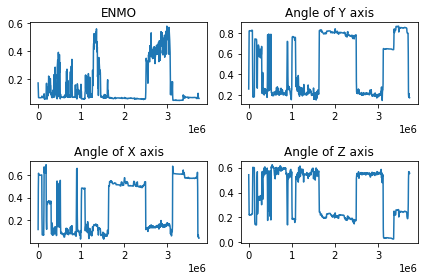

In [25]:
fig, ax = plt.subplots(2, 2)

ax[0,0].title.set_text('ENMO')
ax[0,0].plot(data_example["ENMO"])

ax[1,0].title.set_text('Angle of X axis')
ax[1,0].plot(data_example["anglex"])

ax[0,1].title.set_text('Angle of Y axis')
ax[0,1].plot(data_example["angley"])

ax[1,1].title.set_text('Angle of Z axis')
ax[1,1].plot(data_example["anglez"])

fig.tight_layout()

In [26]:
# This is how data fend into the model looks like
data_example_no_labels = data_example.iloc[0:, 0:4]
data_example_no_labels.head()

ENMO    anglex    angley    anglez
0.0      0.171385  0.118737  0.258163  0.543300
5000.0   0.119792  0.475958  0.626272  0.337458
10000.0  0.066199  0.613919  0.810063  0.220716
15000.0  0.066851  0.598431  0.820968  0.223322
20000.0  0.066307  0.597441  0.818254  0.219889

<AxesSubplot:>

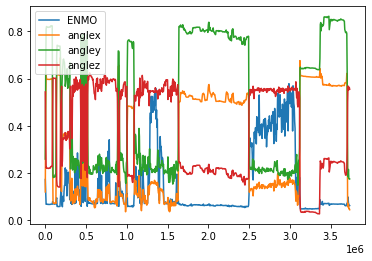

In [28]:
data_example_no_labels.plot()

### Part 5: PyHSMM testing

### Initial run

The parameters for this inital run follows what is recommended by the pyhsmm github.
Taken from examples/hsmm.py

In [57]:
# Dimension of the input data
obs_dim = len(data_example_no_labels.columns)
# Max number of states generated
Nmax = 25

In [58]:
obs_hypparams = {'mu_0':np.zeros(obs_dim),
                'sigma_0':np.eye(obs_dim),
                'kappa_0':0.25,
                'nu_0':obs_dim+2}
dur_hypparams = {'alpha_0':2*30,
                 'beta_0':2}

In [59]:
obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]
dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

In [60]:
run1_posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
        alpha=6.,gamma=6., # these can matter; see concentration-resampling.py
        init_state_concentration=6., # pretty inconsequential
        obs_distns=obs_distns,
        dur_distns=dur_distns)

In [61]:
for participant in features:
    run1_posteriormodel.add_data(features[participant].iloc[0:, 0:4])

In [62]:
for idx in progprint_xrange(150):
    run1_posteriormodel.resample_model()

.........................  [  25/150,    2.20sec avg, ETA 04:35 ]
.........................  [  50/150,    2.17sec avg, ETA 03:37 ]
.........................  [  75/150,    2.16sec avg, ETA 02:42 ]
.........................  [ 100/150,    2.14sec avg, ETA 01:47 ]
.........................  [ 125/150,    2.13sec avg, ETA 53.26 ]
.........................  [ 150/150,    2.13sec avg, ETA 0.00 ]

   2.13sec avg, 05:20 total



In [63]:
plt.figure()
run1_posteriormodel.plot()
plt.gcf().suptitle('Sampled after 150 iterations')
plt.show()

<Figure size 432x288 with 0 Axes>